## SSRGDemo
## Preprocessing Data Input Tables Site Specific RShiny Demo App
Notes:
- asdf

In [1]:
# working with data
import os
import numpy as np
import pandas as pd
import geopandas as gpd # the library that lets us read in shapefiles
import geoplot as gplt # for plotting maps

# visulizaiton
import seaborn as sns
import matplotlib.pyplot as plt

# Cleanup
from datetime import datetime
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

In [2]:
# Working Directory and Input File
workingDir = "C:/Users/rjame/Documents/WSWC Documents/WaDE Side Projects Local/20221017 Rshiny SS Demo/SSRGDemo/NotEssentialData"
os.chdir(workingDir)

## Inputs

In [3]:
#Sites Input
fileInput = "Sites.csv"
dfs = pd.read_csv(fileInput)
print(len(dfs))
dfs.head(1)

11052


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Pacific Gas & Electric,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes


## Clean Sites Data

In [4]:
# Clean input
dfs = dfs.drop_duplicates().reset_index(drop=True) # Drop Duplicate Rows
dfs = dfs.replace(np.nan, "")  # Replaces NaN values with blank.
print(len(dfs))
dfs.head(1)

11052


,SiteUUID,SiteName,SiteNativeID,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords
0,CAssrg_S1,LAKE ALMANOR,ALM,Reservoir Gage,-121.173,40.218,Gage,Surface Water,Pacific Gas & Electric,Reservoir Level,Reservoir Level_Monthly_Storage_Surface Water,Yes


In [5]:
# Fixing blank WaDENameWS
def updateWaDENameWS(Val):
    Val = str(Val).strip()
    if Val == "" or pd.isnull(Val) or Val == "":
        outString = "Unspecified"
    else:
        outString = Val
    return outString

dfs['WaDENameWS'] = dfs.apply(lambda row: updateWaDENameWS(row['WaDENameWS']), axis=1)
dfs['WaDENameWS'].unique()

array(['Surface Water', 'Groundwater', 'Unspecified'], dtype=object)

In [6]:
# Groupby SiteUUID
dfs = dfs.groupby(['SiteNativeID']).agg(lambda x: ", ".join([str(elem) for elem in (list(set(x))) if elem!=""])).replace(np.nan, "").reset_index()
print(len(dfs))
dfs.head(1)

11012


,SiteNativeID,SiteUUID,SiteName,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords
0,0283cf40402a49b39ef0538ff7eec27b,IDssrg_S1,Patterson-Big Springs Creek - Upper,Discharge Point,-113.93825,44.59614,Gage,Surface Water,Patterson-Big Springs Creek - Upper,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes


In [7]:
# count num of VariableSpecificCV after groupby

def countNumVar(Val):
    Val = list(Val.split(","))
    if Val == [""]:
        ValLen = 0
    else:
        ValLen = len(Val)
    return ValLen

dfs['CountVar'] = dfs.apply(lambda row: countNumVar(row['VariableSpecificCV']), axis=1)
dfs['CountVar'].unique()

array([1, 0, 2], dtype=int64)

In [8]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

dfs['State'] = dfs.apply(lambda row: createState(row['SiteUUID']), axis=1)
dfs['State'].unique()

array(['ID', 'NV', 'NE', 'CO', 'OR', 'MT', 'CA'], dtype=object)

In [9]:
# Temp Fix

# remove lat & long entries that contain a ','
dfs = dfs[dfs['Latitude'].str.contains(',') == False]
dfs = dfs[dfs['Longitude'].str.contains(',') == False]

# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).
dfs['Latitude'] = pd.to_numeric(dfs['Latitude'], errors='coerce')
dfs['Longitude'] = pd.to_numeric(dfs['Longitude'], errors='coerce')
dfs = dfs[(dfs['Latitude'].astype(int) > 10) & (dfs['Latitude'].astype(int) < 50)]
dfs = dfs[(dfs['Longitude'].astype(int) < 0) & (dfs['Longitude'].astype(int) > -125)]

print(len(dfs))
dfs.head(1)

11009


,SiteNativeID,SiteUUID,SiteName,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords,CountVar,State
0,0283cf40402a49b39ef0538ff7eec27b,IDssrg_S1,Patterson-Big Springs Creek - Upper,Discharge Point,-113.93825,44.59614,Gage,Surface Water,Patterson-Big Springs Creek - Upper,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID


In [10]:
#Inspect output
dfs

,SiteNativeID,SiteUUID,SiteName,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords,CountVar,State
0,0283cf40402a49b39ef0538ff7eec27b,IDssrg_S1,Patterson-Big Springs Creek - Upper,Discharge Point,-113.938250,44.596140,Gage,Surface Water,Patterson-Big Springs Creek - Upper,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
1,06b16a6c67dd4f0eb70685197cd8cd97,IDssrg_S2,J Drain,Discharge Point,-113.891400,42.531390,Gage,Surface Water,J Drain,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
2,072db346a377493b9d6e572f48e1af9f,IDssrg_S3,Simplot 9,Discharge Point,-116.092209,42.975941,Gage,Surface Water,Simplot 9,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
3,081013086b254450a3c197f0f6259c4b,IDssrg_S4,Texas Creek,Discharge Point,-113.322625,44.636364,Gage,Surface Water,Texas Creek,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
4,09dac063be794c8db48949550c89823d,IDssrg_S5,Blanksma - Chalk Flats,Discharge Point,-115.540444,42.943250,Gage,Surface Water,Blanksma - Chalk Flats,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11007,f9ed24a9a3664fcf81d2d48e27aad215,IDssrg_S173,Bohannon Creek - Upper,Discharge Point,-113.690884,45.190955,Gage,Surface Water,Bohannon Creek - Upper,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
11008,fa194d00570d466491b6d25a9515bedf,IDssrg_S174,Pahsimeroi River at Furey Lane,Discharge Point,-113.847760,44.525690,Gage,Surface Water,Pahsimeroi River at Furey Lane,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
11009,fd4f5c2bd9c649ef9fa20856de66f85d,IDssrg_S175,S19 End,Discharge Point,-114.792000,42.708000,Gage,Surface Water,S19 End,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID
11010,ffd14ef3a62446bebc8c149609fdf18e,IDssrg_S176,Pole Creek,Discharge Point,-114.758440,43.908650,Gage,Surface Water,Pole Creek,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID


In [17]:
dfs['State'].unique()

array(['ID', 'NV', 'NE', 'CO', 'OR', 'MT', 'CA'], dtype=object)

In [18]:
dfs['WaDENameWS'].unique()

array(['Surface Water', 'Groundwater', 'Unspecified'], dtype=object)

In [13]:
# Exporting output files.
dfs.to_excel('Sites_v2.xlsx', index=False)

## Mapping to Validate Sites

In [14]:
# df_sites['Longitude'] = df_sites['Longitude'].astype(float)
# df_sites['Latitude'] = df_sites['Latitude'].astype(float)

In [15]:
# convert dataframe to geodataframe

gdf2 = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.Longitude.astype(float), dfs.Latitude.astype(float)), crs="EPSG:4326")
print(len(gdf2))
gdf2.head()

11009


,SiteNativeID,SiteUUID,SiteName,WaDENameS,Longitude,Latitude,PODorPOUSite,WaDENameWS,CommunityWaterSupplySystem,VariableCV,VariableSpecificCV,HasRecords,CountVar,State,geometry
0,0283cf40402a49b39ef0538ff7eec27b,IDssrg_S1,Patterson-Big Springs Creek - Upper,Discharge Point,-113.938250,44.596140,Gage,Surface Water,Patterson-Big Springs Creek - Upper,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID,POINT (-113.93825 44.59614)
1,06b16a6c67dd4f0eb70685197cd8cd97,IDssrg_S2,J Drain,Discharge Point,-113.891400,42.531390,Gage,Surface Water,J Drain,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID,POINT (-113.89140 42.53139)
2,072db346a377493b9d6e572f48e1af9f,IDssrg_S3,Simplot 9,Discharge Point,-116.092209,42.975941,Gage,Surface Water,Simplot 9,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID,POINT (-116.09221 42.97594)
3,081013086b254450a3c197f0f6259c4b,IDssrg_S4,Texas Creek,Discharge Point,-113.322625,44.636364,Gage,Surface Water,Texas Creek,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID,POINT (-113.32262 44.63636)
4,09dac063be794c8db48949550c89823d,IDssrg_S5,Blanksma - Chalk Flats,Discharge Point,-115.540444,42.943250,Gage,Surface Water,Blanksma - Chalk Flats,Stream Gage,Stream Gage_Daily_Stage_Surface Water,Yes,1,ID,POINT (-115.54044 42.94325)


<AxesSubplot:>

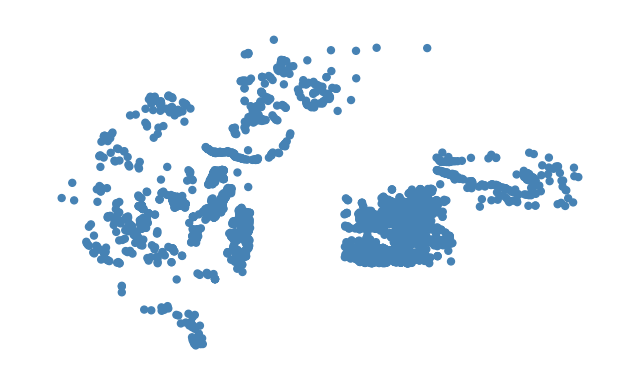

In [16]:
gplt.pointplot(gdf2)